Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

Setup configuration

In [8]:
config = {
    'resolution': 4,
    'num_gens': 20,
    'num_children': 4,
    'mut_sigma': 0.1,
    'init_samples': 3,
}

domain = {
    'name': 'debug',
    'features': [1,2],
    'dof': 6,
    'nfeatures': 2,
    'par_ranges': np.array([[0, 0, 0, 0],[100, 100, 5, 5]]),
    'fit_range': np.array([-5, 5]),
}

def fitness_fun(population, domain):
    fitness = np.random.rand(1,population.shape[0])
    fitness[fitness > 1] = 1.
    fitness[fitness < 0] = 0.
    features = np.random.rand(domain.get('nfeatures'),population.shape[0])
    features[features > 1] = 1.
    features[features < 0] = 0.
    return fitness, features

Method used to create an archive for MAP-Elites

In [3]:
def create_archive(domain, config):
    edges = []
    res = []
    for i in range(len(domain.get('features'))):
        edges.append(np.linspace(0, 1, config.get('resolution')))
        res.append(config.get('resolution'));
    
    empty_archive = np.empty((res))
    empty_archive[:] = np.nan
    fitness = empty_archive
    genes = empty_archive
    genes = np.expand_dims(genes, 2)
    genes = np.tile(genes, (1, 1, domain.get('dof')))
    features = np.tile(empty_archive, (domain.get('nfeatures'), 1, 1))
    
    archive = {'edges': edges,
               'resolution': config.get('resolution'),
               'fitness': fitness, 
               'features': features,
               'genes': genes,}
    return archive

def vis_archive(archive):
    plt.imshow(archive.get('fitness'), cmap='winter')
    plt.clim(0,1)
    plt.show()
    


Method used to create children from a selection of parents

In [4]:
def create_children(archive, domain, config):
    
    # Randomly select parents and copy to children
    pool = archive.get('genes')
    pool = pool.reshape((pool.shape[0]*pool.shape[1], pool.shape[2]))
    selection = np.random.randint(0, pool.shape[0], config.get('num_children'))
    children = np.take(pool, selection, axis=0)
    
    # Mutate children
    ranges = domain.get('par_ranges')
    mutation = np.random.randn(config.get('num_children'),domain.get('dof')) * config.get('mut_sigma')
    mutation = np.transpose(mutation) * (ranges[1]-ranges[0])
    children = children + np.transpose(mutation)
    
    #TODO check par ranges
    
    return children


Method for niche competition

In [5]:
def niche_compete(fitness, features, archive, domain, config):
    assert (features >= 0).all(),"Feature values smaller than 0, assumed to be normalized between [0,1]"
    assert (features <= 1).all(),"Feature values larger than 1, assumed to be normalized between [0,1]"
    assert (fitness >= 0).all(),"Fitness values smaller than 0, assumed to be normalized between [0,1]"
    assert (fitness <= 1).all(),"Fitness values larger than 1, assumed to be normalized between [0,1]"
    
    # Discretize features into bins
    edges = np.linspace(0, 1, num=config.get('resolution'))
    bin_assignment = np.digitize(features,edges)
    bin_assignment = bin_assignment - 1
    
    ## Find highest fitness per bin
    # Sort bins by fitness, then by bin coordinates
    bin_fitness = np.vstack([bin_assignment, fitness])
    num_features = bin_assignment.shape[0]
    idx = (-1*bin_fitness[num_features, :]).argsort()
    bin_fitness = bin_fitness[:, idx]
    for f in range(num_features - 1, -1, -1):
        idy = bin_fitness[f, :].argsort(kind='mergesort')
        bin_fitness = bin_fitness[:, idy]
        idx = idx[idy]    
    unq, ind = np.unique(bin_fitness[0:2,:], return_inverse=False, return_index=True, axis=1)    
    best_index = idx[ind]
    best_bin = bin_assignment[:, best_index]

    # Get replacement IDs in both archive and candidate arrays
    replaced = []
    replacement = []
    for f in range(len(best_index)):
        archive_fitness = archive.get('fitness')
        bin_fitness = archive_fitness[best_bin[0,f],best_bin[1,f]]
        if np.isnan(bin_fitness) or bin_fitness < fitness[:,best_index[f]]:
            replacement.append(best_index[f])
            replaced.append([best_bin[0,f],best_bin[1,f]])

    return replaced, replacement

Replacement function for archive

In [6]:
def update_map(replaced, replacement, archive, fitness, genes, features):
    # Update fitness values
    a_fitness = archive.get('fitness')
    for f in range(len(replaced)):
        a_fitness[replaced[f][0],replaced[f][1]] = fitness[:,replacement[f]]
    archive.update({'fitness': a_fitness})
    
    # Update feature values
    a_features = archive.get('features')
    for f in range(len(replaced)):
        a_features[:,replaced[f][0],replaced[f][1]] = features[:,replacement[f]]
    archive.update({'features': a_features})
    
    # Update gene values
    a_genes = archive.get('genes')
    for f in range(len(replaced)):
        a_genes[replaced[f][0],replaced[f][1],:] = genes[replacement[f],:]
    archive.update({'genes': a_genes})
    
    return archive


MAP-Elites algorithm

Generation: 0/20
Generation: 1/20
Generation: 2/20
Generation: 3/20
Generation: 4/20
Generation: 5/20
Generation: 6/20
Generation: 7/20
Generation: 8/20
Generation: 9/20
Generation: 10/20
Generation: 11/20
Generation: 12/20
Generation: 13/20
Generation: 14/20
Generation: 15/20
Generation: 16/20
Generation: 17/20
Generation: 18/20
Generation: 19/20


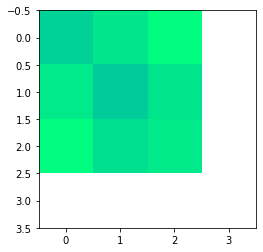

In [14]:
# Initialization
random_pop = np.random.rand(config.get('init_samples'),domain.get('dof'))
archive = create_archive(domain, config)
fitness, features = fitness_fun(random_pop, domain)
replaced, replacement = niche_compete(fitness, features, archive, domain, config)
archive = update_map(replaced, replacement, archive, fitness, random_pop, features)

# Evolution
for iGen in range(config.get('num_gens')):
    print('Generation: ' + str(iGen) + '/' + str(config.get('num_gens')))
    children = np.array([])
    while children.shape[0] < config.get('num_children'):
        new_children = create_children(archive, domain, config)
        children = np.vstack([children, new_children]) if children.size else new_children

    fitness, features = fitness_fun(children, domain)
    replaced, replacement = niche_compete(fitness, features, archive, domain, config)
    archive = update_map(replaced, replacement, archive, fitness, children, features)

vis_archive(archive)
        

